# Exploring Mental Health Data
Duong Tan Loc, Nguyen Viet Hung, Nguyen Viet Nguyen

**Model Training, Model Evaluation, Fine-tuning**

In [2]:
import pandas as pd

In [3]:
df1 = pd.read_csv("./data/data1_feature_eng.csv")

In [4]:
df1.head()

,Age,Have you ever had suicidal thoughts ?,Aca/Work Pressure,Financial Stress,Aca/Work Satisfaction,Working Professional or Student,CGPA,Work/Study Hours,Dietary Habits,Profession,Sleep Duration,Depression
0,49.0,No,5.0,2.0,2.0,Working Professional,NaN,1.0,Healthy,Chef,8.5,0
1,26.0,Yes,4.0,3.0,3.0,Working Professional,NaN,7.0,Unhealthy,Teacher,4.5,1
2,33.0,Yes,5.0,1.0,2.0,Student,8.97,3.0,Healthy,missing,5.5,1
3,22.0,Yes,5.0,1.0,1.0,Working Professional,NaN,10.0,Moderate,Teacher,4.5,1
4,30.0,Yes,1.0,4.0,1.0,Working Professional,NaN,9.0,Unhealthy,Business Analyst,5.5,0


In [5]:
df1.isnull().sum()

Age                                           0
Have you ever had suicidal thoughts ?         0
Aca/Work Pressure                             0
Financial Stress                              0
Aca/Work Satisfaction                         0
Working Professional or Student               0
CGPA                                     112802
Work/Study Hours                              0
Dietary Habits                                0
Profession                                    0
Sleep Duration                                0
Depression                                    0
dtype: int64

## 1. Choose metrics

Dựa trên dataset, ở bước EDA ta thấy rằng tỉ lệ 2 nhãn ở target bị lệch mạnh:
- No Depression chiếm ~80%
- Depression chiếm ~20%

Vì thế, việc chọn metric là accuracy là không phù hợp với bộ dữ liệu này (mặc dù cuộc thi Kaggle chấm bằng Accuracy).


Các metric khác như: Precision, Recall, F1-score, ROC-AUC


Nhóm chọn Recall làm metric chính: 
$$Recall = \frac{\text{Số người bị trầm cảm được phát hiện đúng}}{\text{Tổng số người thật sự bị trầm cảm}}$$

Nếu mô hình có Recall cao, nghĩa là nó có khả năng phát hiện phần lớn người thật sự bị trầm cảm, tránh để họ bị bỏ qua — điều rất quan trọng trong y tế và sức khỏe tâm thần.

Bên cạnh đó, F1-score cũng được sử dụng làm metric phụ, giúp kiểm soát sự cân bằng giữa Precision và Recall

## 2. Model Training

Vì bộ dữ liệu chứ nhiều cột dạng category (không được encoding vì chứa rất nhiều nhãn) nên nhóm chọn model có thể tự xử lí dữ liệu dạng Categorical.

Chọn model:
1. CatBoost
2. LightGBM 

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X, y = df1.drop(columns=["Depression"]), df1["Depression"]

In [8]:
X = X.astype({col: 'category' for col in X.select_dtypes(include='object').columns})

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [10]:
cat_features = [i for i, col in enumerate(X_train.columns) if str(X_train[col].dtype) == 'category']

In [11]:
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

In [12]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [13]:
import optuna

Catboost

In [14]:
def objective(trial):
    # Calculate class weights
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np

    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights_dict = dict(zip(classes, class_weights))

    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "random_strength": trial.suggest_float("random_strength", 0.5, 5.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "task_type": "GPU",
        "loss_function": "Logloss",
        "verbose": 0,
        "random_seed": 42,
        "class_weights": class_weights_dict
    }

    model = CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_test, y_test),
        early_stopping_rounds=50,
        verbose=0
    )

    preds = model.predict(X_test)
    recall = recall_score(y_test, preds, zero_division=0)
    return recall


In [15]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [16]:
# Phase 1: Random Search
study1 = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study1.optimize(objective, n_trials=30)
# study.optimize(objective, timeout=900)

# Results


[I 2025-05-19 13:49:25,265] A new study created in memory with name: no-name-2ea3bc6f-c573-4281-ba5b-089a455f6620
[I 2025-05-19 13:49:32,536] Trial 0 finished with value: 0.9260844193736627 and parameters: {'iterations': 500, 'depth': 10, 'learning_rate': 0.1205712628744377, 'l2_leaf_reg': 6.387926357773329, 'random_strength': 1.2020838819909643, 'bagging_temperature': 0.15599452033620265, 'border_count': 45}. Best is trial 0 with value: 0.9260844193736627.
[I 2025-05-19 13:49:36,103] Trial 1 finished with value: 0.9262789340595214 and parameters: {'iterations': 893, 'depth': 8, 'learning_rate': 0.11114989443094977, 'l2_leaf_reg': 1.185260448662222, 'random_strength': 4.864594334728975, 'bagging_temperature': 0.8324426408004217, 'border_count': 79}. Best is trial 1 with value: 0.9262789340595214.
[I 2025-05-19 13:49:41,089] Trial 2 finished with value: 0.929391169033262 and parameters: {'iterations': 345, 'depth': 5, 'learning_rate': 0.028145092716060652, 'l2_leaf_reg': 5.7228078846901

In [17]:

# Phase 2: TPE fine-tuning
study1.sampler = optuna.samplers.TPESampler(seed=42, n_startup_trials=0)
study1.optimize(objective, n_trials=50)

[I 2025-05-19 13:53:41,604] Trial 30 finished with value: 0.9272515074888154 and parameters: {'iterations': 538, 'depth': 7, 'learning_rate': 0.01725839939375896, 'l2_leaf_reg': 8.49200400176336, 'random_strength': 3.0452589080663146, 'bagging_temperature': 0.4098763370879436, 'border_count': 192}. Best is trial 10 with value: 0.9307527718342735.
[I 2025-05-19 13:53:45,256] Trial 31 finished with value: 0.9309472865201323 and parameters: {'iterations': 265, 'depth': 5, 'learning_rate': 0.01507630087269535, 'l2_leaf_reg': 9.925671256724968, 'random_strength': 2.243619219566331, 'bagging_temperature': 0.4360055044664593, 'border_count': 210}. Best is trial 31 with value: 0.9309472865201323.
[I 2025-05-19 13:53:49,682] Trial 32 finished with value: 0.9313363158918498 and parameters: {'iterations': 312, 'depth': 5, 'learning_rate': 0.01806181802673629, 'l2_leaf_reg': 9.981618135608674, 'random_strength': 3.04139849736647, 'bagging_temperature': 0.6497321967414189, 'border_count': 204}. Bes

In [18]:

import optuna.visualization as vis

# Biểu đồ quá trình tối ưu hóa (Random Search + TPE)
vis.plot_optimization_history(study1).show()

# Biểu đồ tầm quan trọng tham số
vis.plot_param_importances(study1).show()

In [19]:
print("Best recall:", study1.best_value)
print("Best hyperparameters:", study1.best_params)


Best recall: 0.9325034040070025
Best hyperparameters: {'iterations': 389, 'depth': 5, 'learning_rate': 0.019552915646991523, 'l2_leaf_reg': 6.67696080416171, 'random_strength': 1.1703787652887487, 'bagging_temperature': 0.6055885741251384, 'border_count': 238}


LightGBM


In [20]:
import lightgbm as lgb

In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def objective(trial):
    # Compute class weights
    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    # For binary: scale_pos_weight = weight_1 / weight_0
    scale_pos_weight = class_weights[1] / class_weights[0]

    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    train_data = lgb.Dataset(X_tr, label=y_tr)
    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "device": "gpu",
        "max_bin": trial.suggest_int("max_bin", 100, 255),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "seed": 42,
        "scale_pos_weight": scale_pos_weight
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)]
    )

    preds = model.predict(X_val)
    preds_binary = (preds > 0.5).astype(int)
    recall = recall_score(y_val, preds_binary)
    return recall


In [22]:
# Phase 1: Random Search
random_sampler = optuna.samplers.RandomSampler(seed=42)
study2 = optuna.create_study(direction="maximize", sampler=random_sampler)
study2.optimize(objective, n_trials=30)

[I 2025-05-19 13:57:52,304] A new study created in memory with name: no-name-a272d566-8c97-463b-a5fa-1b902cae384f


Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:57:55,165] Trial 0 finished with value: 0.8993880048959608 and parameters: {'max_bin': 158, 'learning_rate': 0.2536999076681772, 'num_leaves': 115, 'max_depth': 8, 'min_data_in_leaf': 32, 'lambda_l1': 0.7799726016810132, 'lambda_l2': 0.2904180608409973, 'feature_fraction': 0.9330880728874675, 'bagging_fraction': 0.8005575058716043, 'bagging_freq': 8, 'min_child_samples': 6}. Best is trial 0 with value: 0.8993880048959608.


Did not meet early stopping. Best iteration is:
[82]	valid_0's binary_logloss: 0.193053
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:57:55,910] Trial 1 finished with value: 0.9277845777233782 and parameters: {'max_bin': 251, 'learning_rate': 0.16967533607196555, 'num_leaves': 47, 'max_depth': 4, 'min_data_in_leaf': 34, 'lambda_l1': 1.5212112147976886, 'lambda_l2': 2.6237821581611893, 'feature_fraction': 0.7159725093210578, 'bagging_fraction': 0.645614570099021, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 1 with value: 0.9277845777233782.


Did not meet early stopping. Best iteration is:
[79]	valid_0's binary_logloss: 0.201233
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:57:58,308] Trial 2 finished with value: 0.9277845777233782 and parameters: {'max_bin': 145, 'learning_rate': 0.03476649150592621, 'num_leaves': 79, 'max_depth': 10, 'min_data_in_leaf': 36, 'lambda_l1': 2.571172192068058, 'lambda_l2': 2.9620728443102124, 'feature_fraction': 0.5232252063599989, 'bagging_fraction': 0.8037724259507192, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 1 with value: 0.9277845777233782.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.209465
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:57:59,534] Trial 3 finished with value: 0.9177478580171359 and parameters: {'max_bin': 248, 'learning_rate': 0.26690431824362526, 'num_leaves': 125, 'max_depth': 6, 'min_data_in_leaf': 27, 'lambda_l1': 3.4211651325607844, 'lambda_l2': 2.2007624686980067, 'feature_fraction': 0.5610191174223894, 'bagging_fraction': 0.7475884550556351, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 1 with value: 0.9277845777233782.


Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_logloss: 0.197762
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:01,261] Trial 4 finished with value: 0.9231334149326805 and parameters: {'max_bin': 140, 'learning_rate': 0.09519754482692679, 'num_leaves': 60, 'max_depth': 8, 'min_data_in_leaf': 64, 'lambda_l1': 0.9242722776276352, 'lambda_l2': 4.847923138822793, 'feature_fraction': 0.8875664116805573, 'bagging_fraction': 0.9697494707820946, 'bagging_freq': 9, 'min_child_samples': 62}. Best is trial 1 with value: 0.9277845777233782.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.196969
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:01,983] Trial 5 finished with value: 0.8609547123623011 and parameters: {'max_bin': 243, 'learning_rate': 0.01351182947645082, 'num_leaves': 45, 'max_depth': 3, 'min_data_in_leaf': 46, 'lambda_l1': 1.9433864484474102, 'lambda_l2': 1.3567451588694794, 'feature_fraction': 0.9143687545759647, 'bagging_fraction': 0.6783766633467947, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 1 with value: 0.9277845777233782.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.261725
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:03,099] Trial 6 finished with value: 0.9248470012239902 and parameters: {'max_bin': 121, 'learning_rate': 0.1530883741573138, 'num_leaves': 29, 'max_depth': 12, 'min_data_in_leaf': 82, 'lambda_l1': 0.993578407670862, 'lambda_l2': 0.027610585618011996, 'feature_fraction': 0.9077307142274171, 'bagging_fraction': 0.8534286719238086, 'bagging_freq': 8, 'min_child_samples': 79}. Best is trial 1 with value: 0.9277845777233782.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.199468
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:04,413] Trial 7 finished with value: 0.9272949816401469 and parameters: {'max_bin': 111, 'learning_rate': 0.0338452204120114, 'num_leaves': 35, 'max_depth': 11, 'min_data_in_leaf': 70, 'lambda_l1': 1.654490124263246, 'lambda_l2': 0.3177917514301182, 'feature_fraction': 0.6554911608578311, 'bagging_fraction': 0.6625916610133735, 'bagging_freq': 8, 'min_child_samples': 66}. Best is trial 1 with value: 0.9277845777233782.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.211162
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:05,779] Trial 8 finished with value: 0.9294981640146879 and parameters: {'max_bin': 238, 'learning_rate': 0.049833191601257244, 'num_leaves': 35, 'max_depth': 10, 'min_data_in_leaf': 81, 'lambda_l1': 2.8063859878474813, 'lambda_l2': 3.854835899772805, 'feature_fraction': 0.7468977981821954, 'bagging_fraction': 0.7613664146909971, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 8 with value: 0.9294981640146879.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.20584
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:07,331] Trial 9 finished with value: 0.8638922888616891 and parameters: {'max_bin': 116, 'learning_rate': 0.011128194768838964, 'num_leaves': 103, 'max_depth': 6, 'min_data_in_leaf': 61, 'lambda_l1': 4.537832369630465, 'lambda_l2': 1.2464611457443748, 'feature_fraction': 0.7051914615178149, 'bagging_fraction': 0.8777755692715243, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 8 with value: 0.9294981640146879.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.250211
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:10,605] Trial 10 finished with value: 0.9084455324357406 and parameters: {'max_bin': 145, 'learning_rate': 0.017303875834205888, 'num_leaves': 141, 'max_depth': 11, 'min_data_in_leaf': 71, 'lambda_l1': 4.357302950938589, 'lambda_l2': 4.018360384495573, 'feature_fraction': 0.5932850294430179, 'bagging_fraction': 0.9462794992449889, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 8 with value: 0.9294981640146879.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.224124
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:11,653] Trial 11 finished with value: 0.9253365973072215 and parameters: {'max_bin': 239, 'learning_rate': 0.02949372944095386, 'num_leaves': 34, 'max_depth': 5, 'min_data_in_leaf': 54, 'lambda_l1': 4.090073829612465, 'lambda_l2': 4.303652916281717, 'feature_fraction': 0.5034760652655954, 'bagging_fraction': 0.7553736512887829, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 8 with value: 0.9294981640146879.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.221126
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:13,273] Trial 12 finished with value: 0.9282741738066096 and parameters: {'max_bin': 118, 'learning_rate': 0.0315281541750961, 'num_leaves': 143, 'max_depth': 6, 'min_data_in_leaf': 62, 'lambda_l1': 3.515094794475889, 'lambda_l2': 1.81814801189647, 'feature_fraction': 0.9858910413604803, 'bagging_fraction': 0.9812236474710556, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 8 with value: 0.9294981640146879.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.208388
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:14,563] Trial 13 finished with value: 0.9258261933904529 and parameters: {'max_bin': 146, 'learning_rate': 0.02634777514406047, 'num_leaves': 24, 'max_depth': 9, 'min_data_in_leaf': 60, 'lambda_l1': 0.25739375624994676, 'lambda_l2': 1.3932323211830573, 'feature_fraction': 0.9541329429833268, 'bagging_fraction': 0.6197809453334862, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 8 with value: 0.9294981640146879.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.217075
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:17,424] Trial 14 finished with value: 0.9189718482252142 and parameters: {'max_bin': 253, 'learning_rate': 0.022779541913782567, 'num_leaves': 108, 'max_depth': 10, 'min_data_in_leaf': 39, 'lambda_l1': 3.641081743059298, 'lambda_l2': 1.838915663596266, 'feature_fraction': 0.8161529152967897, 'bagging_fraction': 0.8167648553804474, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 8 with value: 0.9294981640146879.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.207378
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:18,069] Trial 15 finished with value: 0.9175030599755202 and parameters: {'max_bin': 230, 'learning_rate': 0.029773579612263783, 'num_leaves': 44, 'max_depth': 3, 'min_data_in_leaf': 67, 'lambda_l1': 3.3878218092114123, 'lambda_l2': 0.08293914463928076, 'feature_fraction': 0.7560465291496405, 'bagging_fraction': 0.613247887598969, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 8 with value: 0.9294981640146879.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.237914
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:18,823] Trial 16 finished with value: 0.9314565483476133 and parameters: {'max_bin': 207, 'learning_rate': 0.03726104236509947, 'num_leaves': 142, 'max_depth': 4, 'min_data_in_leaf': 47, 'lambda_l1': 0.5673676062029454, 'lambda_l2': 4.623468091392814, 'feature_fraction': 0.9386696766904905, 'bagging_fraction': 0.6289708138575778, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 16 with value: 0.9314565483476133.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.218953
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:19,433] Trial 17 finished with value: 0.9319461444308446 and parameters: {'max_bin': 186, 'learning_rate': 0.06058402553512053, 'num_leaves': 51, 'max_depth': 3, 'min_data_in_leaf': 92, 'lambda_l1': 4.502090285816652, 'lambda_l2': 3.16550728636634, 'feature_fraction': 0.6695148955243504, 'bagging_fraction': 0.6746047873063304, 'bagging_freq': 8, 'min_child_samples': 91}. Best is trial 17 with value: 0.9319461444308446.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.21714
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:20,097] Trial 18 finished with value: 0.9297429620563036 and parameters: {'max_bin': 238, 'learning_rate': 0.1418961933595484, 'num_leaves': 104, 'max_depth': 3, 'min_data_in_leaf': 33, 'lambda_l1': 4.492770942635397, 'lambda_l2': 3.0321452982979498, 'feature_fraction': 0.5045985258083148, 'bagging_fraction': 0.5507357714330161, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 17 with value: 0.9319461444308446.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.20331
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:22,728] Trial 19 finished with value: 0.9223990208078335 and parameters: {'max_bin': 125, 'learning_rate': 0.064646697464924, 'num_leaves': 110, 'max_depth': 9, 'min_data_in_leaf': 38, 'lambda_l1': 3.560896106737679, 'lambda_l2': 1.1862454374840004, 'feature_fraction': 0.6626998490796339, 'bagging_fraction': 0.8732457025590121, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 17 with value: 0.9319461444308446.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.197364
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:23,933] Trial 20 finished with value: 0.9277845777233782 and parameters: {'max_bin': 202, 'learning_rate': 0.06909724267901692, 'num_leaves': 32, 'max_depth': 6, 'min_data_in_leaf': 41, 'lambda_l1': 1.2199482168954179, 'lambda_l2': 4.865052773762228, 'feature_fraction': 0.6965488623333802, 'bagging_fraction': 0.9460232775885566, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial 17 with value: 0.9319461444308446.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.201993
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:24,634] Trial 21 finished with value: 0.9282741738066096 and parameters: {'max_bin': 178, 'learning_rate': 0.07114706514580525, 'num_leaves': 84, 'max_depth': 4, 'min_data_in_leaf': 78, 'lambda_l1': 1.403861812204279, 'lambda_l2': 0.1215798321572692, 'feature_fraction': 0.822736147953584, 'bagging_fraction': 0.5885553397035245, 'bagging_freq': 10, 'min_child_samples': 96}. Best is trial 17 with value: 0.9319461444308446.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.20515
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:25,731] Trial 22 finished with value: 0.9302325581395349 and parameters: {'max_bin': 242, 'learning_rate': 0.03521837259304686, 'num_leaves': 22, 'max_depth': 12, 'min_data_in_leaf': 54, 'lambda_l1': 4.833274095218348, 'lambda_l2': 4.818099885446264, 'feature_fraction': 0.92650472773368, 'bagging_fraction': 0.6472244460347929, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 17 with value: 0.9319461444308446.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.214227
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:28,525] Trial 23 finished with value: 0.9104039167686658 and parameters: {'max_bin': 149, 'learning_rate': 0.017797595772834227, 'num_leaves': 92, 'max_depth': 12, 'min_data_in_leaf': 76, 'lambda_l1': 2.8503058504468246, 'lambda_l2': 0.4858824688538427, 'feature_fraction': 0.8075036133495849, 'bagging_fraction': 0.9950269250521316, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 17 with value: 0.9319461444308446.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.216546
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:31,648] Trial 24 finished with value: 0.9111383108935128 and parameters: {'max_bin': 236, 'learning_rate': 0.1242238743562571, 'num_leaves': 111, 'max_depth': 10, 'min_data_in_leaf': 49, 'lambda_l1': 1.4679592213224668, 'lambda_l2': 4.046805777392568, 'feature_fraction': 0.9050566973395904, 'bagging_fraction': 0.9335361592900518, 'bagging_freq': 10, 'min_child_samples': 54}. Best is trial 17 with value: 0.9319461444308446.


Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.192182
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:34,684] Trial 25 finished with value: 0.9130966952264382 and parameters: {'max_bin': 178, 'learning_rate': 0.15107019033830843, 'num_leaves': 105, 'max_depth': 10, 'min_data_in_leaf': 84, 'lambda_l1': 4.450026709087831, 'lambda_l2': 1.689975784257679, 'feature_fraction': 0.687791476319972, 'bagging_fraction': 0.5469909699204345, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 17 with value: 0.9319461444308446.


Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.194746
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:36,488] Trial 26 finished with value: 0.9246022031823745 and parameters: {'max_bin': 172, 'learning_rate': 0.06332160636783125, 'num_leaves': 57, 'max_depth': 8, 'min_data_in_leaf': 22, 'lambda_l1': 0.18674094374607209, 'lambda_l2': 4.113002803298292, 'feature_fraction': 0.6800953207056315, 'bagging_fraction': 0.5635302563259423, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 17 with value: 0.9319461444308446.


Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.200383
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:37,174] Trial 27 finished with value: 0.9336597307221542 and parameters: {'max_bin': 133, 'learning_rate': 0.08319261221667239, 'num_leaves': 31, 'max_depth': 3, 'min_data_in_leaf': 63, 'lambda_l1': 2.7031756080505325, 'lambda_l2': 3.187149507491033, 'feature_fraction': 0.8630456668613308, 'bagging_fraction': 0.9879260397312672, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 27 with value: 0.9336597307221542.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.209725
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:38,040] Trial 28 finished with value: 0.9084455324357406 and parameters: {'max_bin': 224, 'learning_rate': 0.025121876414916575, 'num_leaves': 77, 'max_depth': 3, 'min_data_in_leaf': 22, 'lambda_l1': 4.813242073389626, 'lambda_l2': 4.1799006025610295, 'feature_fraction': 0.847987103046849, 'bagging_fraction': 0.7044764722071349, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 27 with value: 0.9336597307221542.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.242565
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:41,090] Trial 29 finished with value: 0.9238678090575275 and parameters: {'max_bin': 139, 'learning_rate': 0.06475515989686911, 'num_leaves': 113, 'max_depth': 9, 'min_data_in_leaf': 42, 'lambda_l1': 4.77432640331597, 'lambda_l2': 3.6894845834788423, 'feature_fraction': 0.7771770262557003, 'bagging_fraction': 0.8058603731171761, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 27 with value: 0.9336597307221542.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.197375


In [23]:
# Phase 2: TPE fine-tuning
tpe_sampler = optuna.samplers.TPESampler(seed=42, n_startup_trials=0)
study2.sampler = tpe_sampler
study2.optimize(objective, n_trials=50)

Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:41,912] Trial 30 finished with value: 0.9348837209302325 and parameters: {'max_bin': 200, 'learning_rate': 0.04691978270865394, 'num_leaves': 66, 'max_depth': 4, 'min_data_in_leaf': 94, 'lambda_l1': 2.1499054778253304, 'lambda_l2': 3.380646823305534, 'feature_fraction': 0.9916353767515115, 'bagging_fraction': 0.7078698353117888, 'bagging_freq': 9, 'min_child_samples': 42}. Best is trial 30 with value: 0.9348837209302325.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.213983
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:42,766] Trial 31 finished with value: 0.9351285189718482 and parameters: {'max_bin': 205, 'learning_rate': 0.04508184739922241, 'num_leaves': 67, 'max_depth': 4, 'min_data_in_leaf': 96, 'lambda_l1': 1.987419215841184, 'lambda_l2': 3.4964600099442964, 'feature_fraction': 0.987878776112855, 'bagging_fraction': 0.7118762375349093, 'bagging_freq': 9, 'min_child_samples': 38}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.214756
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:43,905] Trial 32 finished with value: 0.9343941248470012 and parameters: {'max_bin': 194, 'learning_rate': 0.04668677135952271, 'num_leaves': 65, 'max_depth': 5, 'min_data_in_leaf': 96, 'lambda_l1': 2.1112796218670455, 'lambda_l2': 3.4891455746632087, 'feature_fraction': 0.9918598799154377, 'bagging_fraction': 0.7190650837455672, 'bagging_freq': 9, 'min_child_samples': 40}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.207835
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:45,081] Trial 33 finished with value: 0.9331701346389228 and parameters: {'max_bin': 202, 'learning_rate': 0.048605368875223987, 'num_leaves': 67, 'max_depth': 5, 'min_data_in_leaf': 100, 'lambda_l1': 2.040802005279386, 'lambda_l2': 3.5438600917867036, 'feature_fraction': 0.9997201991654959, 'bagging_fraction': 0.7262229548228248, 'bagging_freq': 9, 'min_child_samples': 40}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.207419
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:46,179] Trial 34 finished with value: 0.9258261933904529 and parameters: {'max_bin': 215, 'learning_rate': 0.08912592514876656, 'num_leaves': 69, 'max_depth': 5, 'min_data_in_leaf': 91, 'lambda_l1': 2.3095451040792567, 'lambda_l2': 2.483233467590634, 'feature_fraction': 0.9683459003847593, 'bagging_fraction': 0.5077551909971136, 'bagging_freq': 9, 'min_child_samples': 40}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.200864
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:47,036] Trial 35 finished with value: 0.9339045287637698 and parameters: {'max_bin': 191, 'learning_rate': 0.044073943290534275, 'num_leaves': 69, 'max_depth': 4, 'min_data_in_leaf': 99, 'lambda_l1': 2.4271328985280887, 'lambda_l2': 3.275355128929287, 'feature_fraction': 0.8747340093732265, 'bagging_fraction': 0.715946509126248, 'bagging_freq': 9, 'min_child_samples': 38}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.215124
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:47,822] Trial 36 finished with value: 0.9348837209302325 and parameters: {'max_bin': 190, 'learning_rate': 0.04248875071184361, 'num_leaves': 71, 'max_depth': 4, 'min_data_in_leaf': 100, 'lambda_l1': 2.1989859412714856, 'lambda_l2': 3.4045546405077225, 'feature_fraction': 0.9705173746828246, 'bagging_fraction': 0.7089289020157835, 'bagging_freq': 9, 'min_child_samples': 43}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.21604
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:49,858] Trial 37 finished with value: 0.9275397796817626 and parameters: {'max_bin': 163, 'learning_rate': 0.04294735990571919, 'num_leaves': 91, 'max_depth': 7, 'min_data_in_leaf': 93, 'lambda_l1': 1.8973028109067687, 'lambda_l2': 2.851194501918022, 'feature_fraction': 0.9630023110923424, 'bagging_fraction': 0.7770795516431379, 'bagging_freq': 10, 'min_child_samples': 45}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.201577
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:50,896] Trial 38 finished with value: 0.9275397796817626 and parameters: {'max_bin': 190, 'learning_rate': 0.10853485947242389, 'num_leaves': 76, 'max_depth': 5, 'min_data_in_leaf': 87, 'lambda_l1': 3.029423301406538, 'lambda_l2': 3.482421626421597, 'feature_fraction': 0.9959662745823737, 'bagging_fraction': 0.7044470004539679, 'bagging_freq': 9, 'min_child_samples': 34}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.200623
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:51,684] Trial 39 finished with value: 0.9329253365973073 and parameters: {'max_bin': 219, 'learning_rate': 0.041350521253808524, 'num_leaves': 60, 'max_depth': 4, 'min_data_in_leaf': 96, 'lambda_l1': 2.174247627927644, 'lambda_l2': 2.586440907951697, 'feature_fraction': 0.9425565772878735, 'bagging_fraction': 0.7349074171376353, 'bagging_freq': 8, 'min_child_samples': 44}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.21648
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:53,248] Trial 40 finished with value: 0.9290085679314566 and parameters: {'max_bin': 196, 'learning_rate': 0.052394285629805554, 'num_leaves': 53, 'max_depth': 7, 'min_data_in_leaf': 87, 'lambda_l1': 1.8155167872474565, 'lambda_l2': 2.8102620839200716, 'feature_fraction': 0.9706826997984906, 'bagging_fraction': 0.6926209519870974, 'bagging_freq': 10, 'min_child_samples': 67}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.201409
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:54,016] Trial 41 finished with value: 0.9331701346389228 and parameters: {'max_bin': 211, 'learning_rate': 0.044003373742874795, 'num_leaves': 65, 'max_depth': 4, 'min_data_in_leaf': 98, 'lambda_l1': 2.452874266004143, 'lambda_l2': 3.251165814568011, 'feature_fraction': 0.8826831489361608, 'bagging_fraction': 0.7261479833729136, 'bagging_freq': 9, 'min_child_samples': 31}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.215391
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:55,086] Trial 42 finished with value: 0.9294981640146879 and parameters: {'max_bin': 194, 'learning_rate': 0.03933194278223129, 'num_leaves': 73, 'max_depth': 5, 'min_data_in_leaf': 96, 'lambda_l1': 2.4283586752767334, 'lambda_l2': 3.732580121705033, 'feature_fraction': 0.9123441456152667, 'bagging_fraction': 0.7702570633315006, 'bagging_freq': 9, 'min_child_samples': 47}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.210801
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:55,845] Trial 43 finished with value: 0.9329253365973073 and parameters: {'max_bin': 186, 'learning_rate': 0.05482372616792525, 'num_leaves': 88, 'max_depth': 4, 'min_data_in_leaf': 100, 'lambda_l1': 1.6659310608044866, 'lambda_l2': 3.3965590412159568, 'feature_fraction': 0.9717961754249553, 'bagging_fraction': 0.6540295361954918, 'bagging_freq': 8, 'min_child_samples': 37}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.210732
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:56,854] Trial 44 finished with value: 0.9219094247246022 and parameters: {'max_bin': 166, 'learning_rate': 0.18925428711901468, 'num_leaves': 82, 'max_depth': 5, 'min_data_in_leaf': 89, 'lambda_l1': 2.1587060430543343, 'lambda_l2': 2.3345884066587823, 'feature_fraction': 0.8811573017631228, 'bagging_fraction': 0.7833913360859688, 'bagging_freq': 10, 'min_child_samples': 41}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.199066
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:58,165] Trial 45 finished with value: 0.9199510403916769 and parameters: {'max_bin': 201, 'learning_rate': 0.021801646710671082, 'num_leaves': 43, 'max_depth': 6, 'min_data_in_leaf': 95, 'lambda_l1': 3.1995935228699723, 'lambda_l2': 4.427826159452118, 'feature_fraction': 0.9276512292588397, 'bagging_fraction': 0.7124634449854014, 'bagging_freq': 9, 'min_child_samples': 25}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.215923
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:58,923] Trial 46 finished with value: 0.9304773561811506 and parameters: {'max_bin': 185, 'learning_rate': 0.07944130544745046, 'num_leaves': 63, 'max_depth': 4, 'min_data_in_leaf': 83, 'lambda_l1': 2.6252663079444236, 'lambda_l2': 3.824934599898315, 'feature_fraction': 0.9848742006354215, 'bagging_fraction': 0.6816657071829747, 'bagging_freq': 8, 'min_child_samples': 61}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.205506
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:58:59,704] Trial 47 finished with value: 0.9324357405140759 and parameters: {'max_bin': 173, 'learning_rate': 0.04766782867641253, 'num_leaves': 98, 'max_depth': 4, 'min_data_in_leaf': 88, 'lambda_l1': 1.2498281154166735, 'lambda_l2': 2.779911808035703, 'feature_fraction': 0.9508060769744663, 'bagging_fraction': 0.8328464877975107, 'bagging_freq': 9, 'min_child_samples': 32}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.214194
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:00,769] Trial 48 finished with value: 0.9326805385556916 and parameters: {'max_bin': 207, 'learning_rate': 0.05626210959727794, 'num_leaves': 72, 'max_depth': 5, 'min_data_in_leaf': 94, 'lambda_l1': 1.744607640085737, 'lambda_l2': 3.382506020206207, 'feature_fraction': 0.8983366707986518, 'bagging_fraction': 0.7312671622009199, 'bagging_freq': 8, 'min_child_samples': 48}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.205326
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:01,426] Trial 49 finished with value: 0.9187270501835986 and parameters: {'max_bin': 156, 'learning_rate': 0.03234009147355121, 'num_leaves': 123, 'max_depth': 3, 'min_data_in_leaf': 100, 'lambda_l1': 2.2085278581986754, 'lambda_l2': 3.028871870558301, 'feature_fraction': 0.6225658394072078, 'bagging_fraction': 0.7554954714731361, 'bagging_freq': 10, 'min_child_samples': 59}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.236542
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:02,231] Trial 50 finished with value: 0.9228886168910648 and parameters: {'max_bin': 220, 'learning_rate': 0.291903954644292, 'num_leaves': 56, 'max_depth': 4, 'min_data_in_leaf': 78, 'lambda_l1': 2.9200208874748164, 'lambda_l2': 3.570964050460332, 'feature_fraction': 0.932408436389056, 'bagging_fraction': 0.6631905656770462, 'bagging_freq': 9, 'min_child_samples': 43}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.200773
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:02,881] Trial 51 finished with value: 0.9329253365973073 and parameters: {'max_bin': 196, 'learning_rate': 0.08189050485460732, 'num_leaves': 41, 'max_depth': 3, 'min_data_in_leaf': 91, 'lambda_l1': 2.6720840639110346, 'lambda_l2': 3.2531453777465225, 'feature_fraction': 0.8604097902003466, 'bagging_fraction': 0.9084303897685047, 'bagging_freq': 8, 'min_child_samples': 37}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.209791
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:03,544] Trial 52 finished with value: 0.9287637698898409 and parameters: {'max_bin': 101, 'learning_rate': 0.036412515475062676, 'num_leaves': 48, 'max_depth': 3, 'min_data_in_leaf': 72, 'lambda_l1': 2.5414575966698685, 'lambda_l2': 3.8812655779685015, 'feature_fraction': 0.9804386378710281, 'bagging_fraction': 0.7495242544514227, 'bagging_freq': 9, 'min_child_samples': 37}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.232307
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:04,443] Trial 53 finished with value: 0.9285189718482252 and parameters: {'max_bin': 181, 'learning_rate': 0.10298379197443168, 'num_leaves': 79, 'max_depth': 4, 'min_data_in_leaf': 97, 'lambda_l1': 2.0469577575004236, 'lambda_l2': 3.11324020698052, 'feature_fraction': 0.8603681192290878, 'bagging_fraction': 0.6812868600549168, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.203297
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:05,065] Trial 54 finished with value: 0.9341493268053855 and parameters: {'max_bin': 192, 'learning_rate': 0.0764518135644965, 'num_leaves': 64, 'max_depth': 3, 'min_data_in_leaf': 29, 'lambda_l1': 2.7080013777554974, 'lambda_l2': 2.1506911411724703, 'feature_fraction': 0.999898989225217, 'bagging_fraction': 0.7944476669461006, 'bagging_freq': 8, 'min_child_samples': 25}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.211116
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:06,561] Trial 55 finished with value: 0.9297429620563036 and parameters: {'max_bin': 191, 'learning_rate': 0.04581064605576506, 'num_leaves': 62, 'max_depth': 6, 'min_data_in_leaf': 86, 'lambda_l1': 3.8650380370286523, 'lambda_l2': 2.074013508630693, 'feature_fraction': 0.9975415748394822, 'bagging_fraction': 0.7880807775833487, 'bagging_freq': 8, 'min_child_samples': 28}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.204561
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:07,300] Trial 56 finished with value: 0.9241126070991432 and parameters: {'max_bin': 207, 'learning_rate': 0.027554074192096937, 'num_leaves': 70, 'max_depth': 4, 'min_data_in_leaf': 90, 'lambda_l1': 2.39423303998019, 'lambda_l2': 2.1943541871076553, 'feature_fraction': 0.9546551459819144, 'bagging_fraction': 0.7107349167827728, 'bagging_freq': 10, 'min_child_samples': 17}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.225839
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:08,369] Trial 57 finished with value: 0.9285189718482252 and parameters: {'max_bin': 198, 'learning_rate': 0.07304675662460422, 'num_leaves': 58, 'max_depth': 5, 'min_data_in_leaf': 26, 'lambda_l1': 3.2023850556672118, 'lambda_l2': 2.6545274801280696, 'feature_fraction': 0.9491783106874122, 'bagging_fraction': 0.8446287211186333, 'bagging_freq': 9, 'min_child_samples': 25}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.202755
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:09,035] Trial 58 finished with value: 0.9351285189718482 and parameters: {'max_bin': 229, 'learning_rate': 0.05719502203375969, 'num_leaves': 50, 'max_depth': 3, 'min_data_in_leaf': 29, 'lambda_l1': 1.5656132501609672, 'lambda_l2': 2.4160745127730205, 'feature_fraction': 0.9754828852273139, 'bagging_fraction': 0.6387496922982776, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.217983
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:09,694] Trial 59 finished with value: 0.9346389228886169 and parameters: {'max_bin': 212, 'learning_rate': 0.05562913249553195, 'num_leaves': 50, 'max_depth': 3, 'min_data_in_leaf': 31, 'lambda_l1': 0.8346051245534349, 'lambda_l2': 2.0394626748961846, 'feature_fraction': 0.9816429511422359, 'bagging_fraction': 0.6239306304147187, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.218837
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:10,403] Trial 60 finished with value: 0.9312117503059976 and parameters: {'max_bin': 230, 'learning_rate': 0.059844336833392714, 'num_leaves': 51, 'max_depth': 3, 'min_data_in_leaf': 36, 'lambda_l1': 0.7537838030926043, 'lambda_l2': 1.5448879041663477, 'feature_fraction': 0.5538332346301196, 'bagging_fraction': 0.6272123035804698, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.217406
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:11,032] Trial 61 finished with value: 0.9339045287637698 and parameters: {'max_bin': 213, 'learning_rate': 0.052411041808596674, 'num_leaves': 54, 'max_depth': 3, 'min_data_in_leaf': 29, 'lambda_l1': 1.1583150756473048, 'lambda_l2': 2.390380978367526, 'feature_fraction': 0.9800591637974377, 'bagging_fraction': 0.6016959563072467, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.2206
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:11,685] Trial 62 finished with value: 0.9299877600979192 and parameters: {'max_bin': 226, 'learning_rate': 0.03916916560084884, 'num_leaves': 38, 'max_depth': 3, 'min_data_in_leaf': 31, 'lambda_l1': 1.5923878193755365, 'lambda_l2': 2.1750813055582148, 'feature_fraction': 0.9214988570717828, 'bagging_fraction': 0.632553010691554, 'bagging_freq': 8, 'min_child_samples': 16}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.22886
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:12,357] Trial 63 finished with value: 0.9326805385556916 and parameters: {'max_bin': 218, 'learning_rate': 0.07490022065833138, 'num_leaves': 47, 'max_depth': 3, 'min_data_in_leaf': 25, 'lambda_l1': 0.5347083923169882, 'lambda_l2': 1.9067906822290424, 'feature_fraction': 0.9587873131203865, 'bagging_fraction': 0.5898098341190013, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.211253
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:13,169] Trial 64 finished with value: 0.9336597307221542 and parameters: {'max_bin': 207, 'learning_rate': 0.057602459768790436, 'num_leaves': 65, 'max_depth': 4, 'min_data_in_leaf': 55, 'lambda_l1': 0.899744817335566, 'lambda_l2': 1.0858065348893984, 'feature_fraction': 0.9996836035186943, 'bagging_fraction': 0.6666333900716122, 'bagging_freq': 8, 'min_child_samples': 34}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.209393
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:13,824] Trial 65 finished with value: 0.9339045287637698 and parameters: {'max_bin': 203, 'learning_rate': 0.0679778785788234, 'num_leaves': 49, 'max_depth': 3, 'min_data_in_leaf': 20, 'lambda_l1': 0.021328242984183454, 'lambda_l2': 1.9377278288379403, 'feature_fraction': 0.9774891897921378, 'bagging_fraction': 0.6384564687874141, 'bagging_freq': 8, 'min_child_samples': 21}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.213432
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:14,538] Trial 66 finished with value: 0.9241126070991432 and parameters: {'max_bin': 230, 'learning_rate': 0.033513275231045865, 'num_leaves': 75, 'max_depth': 3, 'min_data_in_leaf': 35, 'lambda_l1': 1.9818709599617865, 'lambda_l2': 2.9376294250160457, 'feature_fraction': 0.9444320977606515, 'bagging_fraction': 0.743475845815551, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.234412
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:15,372] Trial 67 finished with value: 0.9341493268053855 and parameters: {'max_bin': 183, 'learning_rate': 0.049897537893841375, 'num_leaves': 82, 'max_depth': 4, 'min_data_in_leaf': 29, 'lambda_l1': 1.5327821160544972, 'lambda_l2': 1.704717740607331, 'feature_fraction': 0.98480880574546, 'bagging_fraction': 0.8008500924954685, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.212845
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:16,189] Trial 68 finished with value: 0.9223990208078335 and parameters: {'max_bin': 173, 'learning_rate': 0.0297976963590805, 'num_leaves': 62, 'max_depth': 4, 'min_data_in_leaf': 33, 'lambda_l1': 1.8309887345654055, 'lambda_l2': 2.3249188918867394, 'feature_fraction': 0.7255901155023388, 'bagging_fraction': 0.6959789424651549, 'bagging_freq': 1, 'min_child_samples': 42}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.224771
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:17,234] Trial 69 finished with value: 0.9285189718482252 and parameters: {'max_bin': 250, 'learning_rate': 0.09335903553586765, 'num_leaves': 58, 'max_depth': 5, 'min_data_in_leaf': 45, 'lambda_l1': 2.122286860820875, 'lambda_l2': 2.034339051782892, 'feature_fraction': 0.9643056582804245, 'bagging_fraction': 0.7636673562275365, 'bagging_freq': 10, 'min_child_samples': 29}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.201063
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:17,868] Trial 70 finished with value: 0.9336597307221542 and parameters: {'max_bin': 213, 'learning_rate': 0.06257472941693819, 'num_leaves': 38, 'max_depth': 3, 'min_data_in_leaf': 39, 'lambda_l1': 2.28125616947744, 'lambda_l2': 3.934293915968562, 'feature_fraction': 0.9398395548934497, 'bagging_fraction': 0.5750251721279527, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.215073
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:18,670] Trial 71 finished with value: 0.9348837209302325 and parameters: {'max_bin': 184, 'learning_rate': 0.05195705393616168, 'num_leaves': 80, 'max_depth': 4, 'min_data_in_leaf': 29, 'lambda_l1': 1.4312690049321382, 'lambda_l2': 1.684882690279493, 'feature_fraction': 0.9895810892549584, 'bagging_fraction': 0.7894162991487933, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.211775
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:19,504] Trial 72 finished with value: 0.9341493268053855 and parameters: {'max_bin': 189, 'learning_rate': 0.048731318542359126, 'num_leaves': 66, 'max_depth': 4, 'min_data_in_leaf': 24, 'lambda_l1': 1.2818870552575918, 'lambda_l2': 1.485986156771009, 'feature_fraction': 0.9888584771916799, 'bagging_fraction': 0.8163166892521592, 'bagging_freq': 5, 'min_child_samples': 67}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.213828
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:20,101] Trial 73 finished with value: 0.9304773561811506 and parameters: {'max_bin': 201, 'learning_rate': 0.03789014125879525, 'num_leaves': 73, 'max_depth': 3, 'min_data_in_leaf': 29, 'lambda_l1': 1.4233452130222912, 'lambda_l2': 0.792248953836332, 'feature_fraction': 0.9665503258248651, 'bagging_fraction': 0.6094341483133447, 'bagging_freq': 8, 'min_child_samples': 45}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.229868
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:20,871] Trial 74 finished with value: 0.9321909424724603 and parameters: {'max_bin': 177, 'learning_rate': 0.0552419196379979, 'num_leaves': 150, 'max_depth': 4, 'min_data_in_leaf': 27, 'lambda_l1': 1.9413536541173382, 'lambda_l2': 2.6467999056162617, 'feature_fraction': 0.902302554258457, 'bagging_fraction': 0.6936725301878454, 'bagging_freq': 9, 'min_child_samples': 40}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.210243
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:21,503] Trial 75 finished with value: 0.9299877600979192 and parameters: {'max_bin': 194, 'learning_rate': 0.04223263689050182, 'num_leaves': 79, 'max_depth': 3, 'min_data_in_leaf': 32, 'lambda_l1': 1.0783270305655486, 'lambda_l2': 1.6841229921511638, 'feature_fraction': 0.9990774515470227, 'bagging_fraction': 0.793970711086059, 'bagging_freq': 7, 'min_child_samples': 27}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.227248
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:22,583] Trial 76 finished with value: 0.9304773561811506 and parameters: {'max_bin': 246, 'learning_rate': 0.06722896549356625, 'num_leaves': 87, 'max_depth': 5, 'min_data_in_leaf': 57, 'lambda_l1': 1.7378532932592257, 'lambda_l2': 3.679896197223497, 'feature_fraction': 0.9729584505973069, 'bagging_fraction': 0.6548156131904764, 'bagging_freq': 6, 'min_child_samples': 52}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.203132
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:23,374] Trial 77 finished with value: 0.9336597307221542 and parameters: {'max_bin': 210, 'learning_rate': 0.05192840879330324, 'num_leaves': 97, 'max_depth': 4, 'min_data_in_leaf': 67, 'lambda_l1': 0.6436884751372547, 'lambda_l2': 2.5072363510572253, 'feature_fraction': 0.9569160064438108, 'bagging_fraction': 0.8310814727512301, 'bagging_freq': 8, 'min_child_samples': 72}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.212137
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:24,192] Trial 78 finished with value: 0.8450428396572828 and parameters: {'max_bin': 187, 'learning_rate': 0.01012200996415682, 'num_leaves': 27, 'max_depth': 4, 'min_data_in_leaf': 22, 'lambda_l1': 1.352484505132619, 'lambda_l2': 3.426666668776168, 'feature_fraction': 0.9209453146401269, 'bagging_fraction': 0.7428966315286737, 'bagging_freq': 8, 'min_child_samples': 35}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.263995
Training until validation scores don't improve for 50 rounds


[I 2025-05-19 13:59:24,833] Trial 79 finished with value: 0.9324357405140759 and parameters: {'max_bin': 199, 'learning_rate': 0.04563985307841082, 'num_leaves': 68, 'max_depth': 3, 'min_data_in_leaf': 93, 'lambda_l1': 1.0358649241320377, 'lambda_l2': 1.8012477970761431, 'feature_fraction': 0.9833417086408689, 'bagging_fraction': 0.7676949735648176, 'bagging_freq': 9, 'min_child_samples': 46}. Best is trial 31 with value: 0.9351285189718482.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.225195


In [24]:
# Biểu đồ quá trình tối ưu hóa (Random Search + TPE)
vis.plot_optimization_history(study2).show()

# Biểu đồ tầm quan trọng tham số
vis.plot_param_importances(study2).show()

In [25]:

print("Best recall:", study2.best_value)
print("Best hyperparameters:", study2.best_params)

Best recall: 0.9351285189718482
Best hyperparameters: {'max_bin': 205, 'learning_rate': 0.04508184739922241, 'num_leaves': 67, 'max_depth': 4, 'min_data_in_leaf': 96, 'lambda_l1': 1.987419215841184, 'lambda_l2': 3.4964600099442964, 'feature_fraction': 0.987878776112855, 'bagging_fraction': 0.7118762375349093, 'bagging_freq': 9, 'min_child_samples': 38}


In [26]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
scale_pos_weight = class_weights[1] / class_weights[0]


In [27]:
original_catmodel = CatBoostClassifier(random_seed=42, class_weights= class_weights_dict, task_type= "GPU", loss_function="Logloss", verbose=0)
original_catmodel.fit(X_train, y_train, cat_features=cat_features)

tuned_catmodel = CatBoostClassifier(**study1.best_params,class_weights= class_weights_dict, random_seed=42, task_type="GPU", loss_function="Logloss", verbose=0)
tuned_catmodel.fit(X_train, y_train, cat_features=cat_features)

original_lgbmmodel = LGBMClassifier(random_state=42, device="gpu", scale_pos_weight= scale_pos_weight)
original_lgbmmodel.fit(X_train, y_train)

tuned_lgbmodel = LGBMClassifier(**study2.best_params,scale_pos_weight= scale_pos_weight, random_state=42, device="gpu")
tuned_lgbmodel.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.7118762375349093, bagging_freq=9,
               device='gpu', feature_fraction=0.987878776112855,
               lambda_l1=1.987419215841184, lambda_l2=3.4964600099442964,
               learning_rate=0.04508184739922241, max_bin=205, max_depth=4,
               min_child_samples=38, min_data_in_leaf=96, num_leaves=67,
               random_state=42, scale_pos_weight=4.5106237148732005)

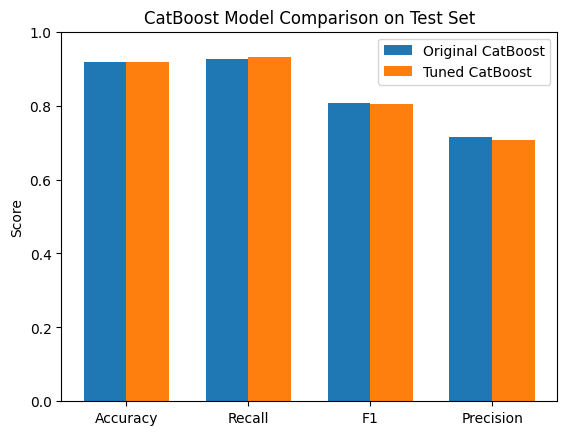

In [28]:
import numpy as np

# Predict with original and tuned CatBoost models
y_pred_orig_cat = original_catmodel.predict(X_test)
y_pred_tuned_cat = tuned_catmodel.predict(X_test)

# Calculate metrics
metrics = {
    "Accuracy": [
        accuracy_score(y_test, y_pred_orig_cat),
        accuracy_score(y_test, y_pred_tuned_cat)
    ],
    "Recall": [
        recall_score(y_test, y_pred_orig_cat),
        recall_score(y_test, y_pred_tuned_cat)
    ],
    "F1": [
        f1_score(y_test, y_pred_orig_cat),
        f1_score(y_test, y_pred_tuned_cat)
    ],
    "Precision": [
        precision_score(y_test, y_pred_orig_cat),
        precision_score(y_test, y_pred_tuned_cat)
    ]
}

import matplotlib.pyplot as plt

labels = list(metrics.keys())
orig_scores = [metrics[m][0] for m in labels]
tuned_scores = [metrics[m][1] for m in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, orig_scores, width, label='Original CatBoost')
rects2 = ax.bar(x + width/2, tuned_scores, width, label='Tuned CatBoost')

ax.set_ylabel('Score')
ax.set_title('CatBoost Model Comparison on Test Set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 1)
plt.show()

In [29]:
metrics

{'Accuracy': [0.9191897654584221, 0.9174484719260839],
 'Recall': [0.9260844193736627, 0.932114374635285],
 'F1': [0.8072227873855544, 0.804904677920551],
 'Precision': [0.7154019534184823, 0.7082471179426545]}

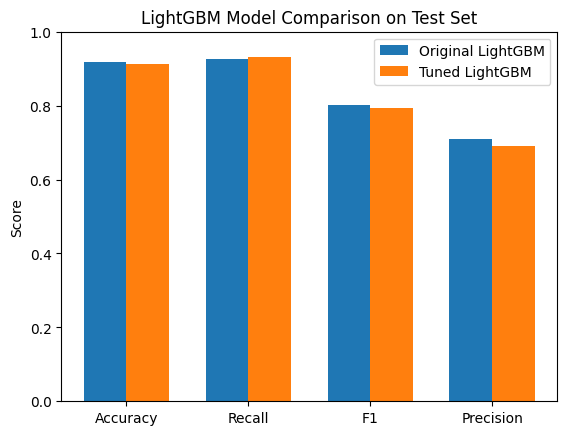

In [30]:
# Predict with original and tuned LightGBM models
y_pred_orig_lgb = original_lgbmmodel.predict(X_test)
y_pred_tuned_lgb = tuned_lgbmodel.predict(X_test)

# Calculate metrics
metrics_lgb = {
    "Accuracy": [
        accuracy_score(y_test, y_pred_orig_lgb),
        accuracy_score(y_test, y_pred_tuned_lgb)
    ],
    "Recall": [
        recall_score(y_test, y_pred_orig_lgb),
        recall_score(y_test, y_pred_tuned_lgb)
    ],
    "F1": [
        f1_score(y_test, y_pred_orig_lgb),
        f1_score(y_test, y_pred_tuned_lgb)
    ],
    "Precision": [
        precision_score(y_test, y_pred_orig_lgb),
        precision_score(y_test, y_pred_tuned_lgb)
    ]
}

labels_lgb = list(metrics_lgb.keys())
orig_scores_lgb = [metrics_lgb[m][0] for m in labels_lgb]
tuned_scores_lgb = [metrics_lgb[m][1] for m in labels_lgb]

x_lgb = np.arange(len(labels_lgb))
width_lgb = 0.35

fig_lgb, ax_lgb = plt.subplots()
rects1_lgb = ax_lgb.bar(x_lgb - width_lgb/2, orig_scores_lgb, width_lgb, label='Original LightGBM')
rects2_lgb = ax_lgb.bar(x_lgb + width_lgb/2, tuned_scores_lgb, width_lgb, label='Tuned LightGBM')

ax_lgb.set_ylabel('Score')
ax_lgb.set_title('LightGBM Model Comparison on Test Set')
ax_lgb.set_xticks(x_lgb)
ax_lgb.set_xticklabels(labels_lgb)
ax_lgb.legend()
plt.ylim(0, 1)
plt.show()

In [31]:
metrics_lgb

{'Accuracy': [0.9169154228855722, 0.9112295664534471],
 'Recall': [0.9256953900019451, 0.9303637424625559],
 'F1': [0.8028002699055331, 0.7929376657824934],
 'Precision': [0.7087118391660462, 0.6908854542828253]}

In [32]:
# Get predicted probabilities from both models
proba_cat = tuned_catmodel.predict_proba(X_test)
proba_lgb = tuned_lgbmodel.predict_proba(X_test)

# Average the probabilities
avg_proba = (proba_cat + proba_lgb) / 2

# Take the class with the highest probability
y_pred_manual_soft = avg_proba.argmax(axis=1)


In [33]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

# Evaluate soft voting predictions
accuracy_soft = accuracy_score(y_test, y_pred_manual_soft)
recall_soft = recall_score(y_test, y_pred_manual_soft)
f1_soft = f1_score(y_test, y_pred_manual_soft)
precision_soft = precision_score(y_test, y_pred_manual_soft)

print("Soft Voting Results:")
print(f"Accuracy: {accuracy_soft:.4f}")
print(f"Recall: {recall_soft:.4f}")
print(f"F1 Score: {f1_soft:.4f}")
print(f"Precision: {precision_soft:.4f}")

Soft Voting Results:
Accuracy: 0.9156
Recall: 0.9327
F1 Score: 0.8015
Precision: 0.7027


,Model,Accuracy,Recall,F1-score,Precision
0,CatBoost,0.917448,0.932114,0.804905,0.708247
1,LightGBM,0.911230,0.930364,0.792938,0.690885
2,Ensemble,0.915601,0.932698,0.801504,0.702667


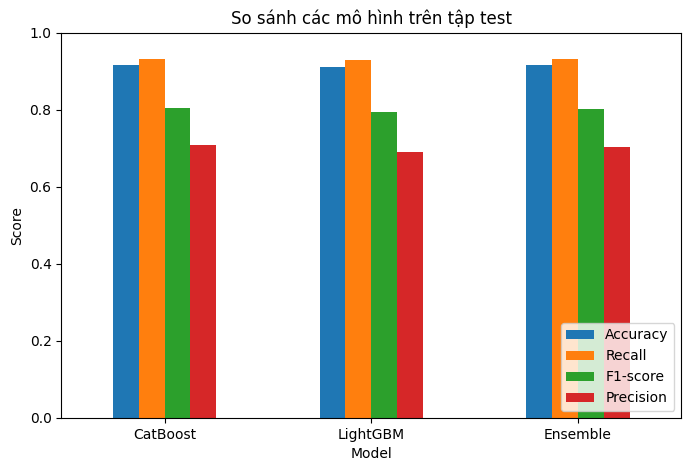

In [34]:
# Tạo bảng tổng hợp kết quả
results = pd.DataFrame({
    "Model": ["CatBoost", "LightGBM", "Ensemble"],
    "Accuracy": [
        metrics["Accuracy"][1],      # Tuned CatBoost
        metrics_lgb["Accuracy"][1],  # Tuned LightGBM
        accuracy_soft                # Ensemble
    ],
    "Recall": [
        metrics["Recall"][1],
        metrics_lgb["Recall"][1],
        recall_soft
    ],
    "F1-score": [
        metrics["F1"][1],
        metrics_lgb["F1"][1],
        f1_soft
    ],
    "Precision": [
        metrics["Precision"][1],
        metrics_lgb["Precision"][1],
        precision_soft
    ]
})

display(results)

# Vẽ biểu đồ trực quan
results_plot = results.set_index("Model")
results_plot.plot(kind="bar", figsize=(8,5))
plt.title("So sánh các mô hình trên tập test")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

Các kết quả: cả 3 mô hình đều đạt được những điểm số trên các metric như nhau:

Accuracy: 0.91	Recall: 0.93	F1: 0.80	Precision: 0.70

## Kiểm tra các trường hợp dự đoán sai của mô hình và ensemble model

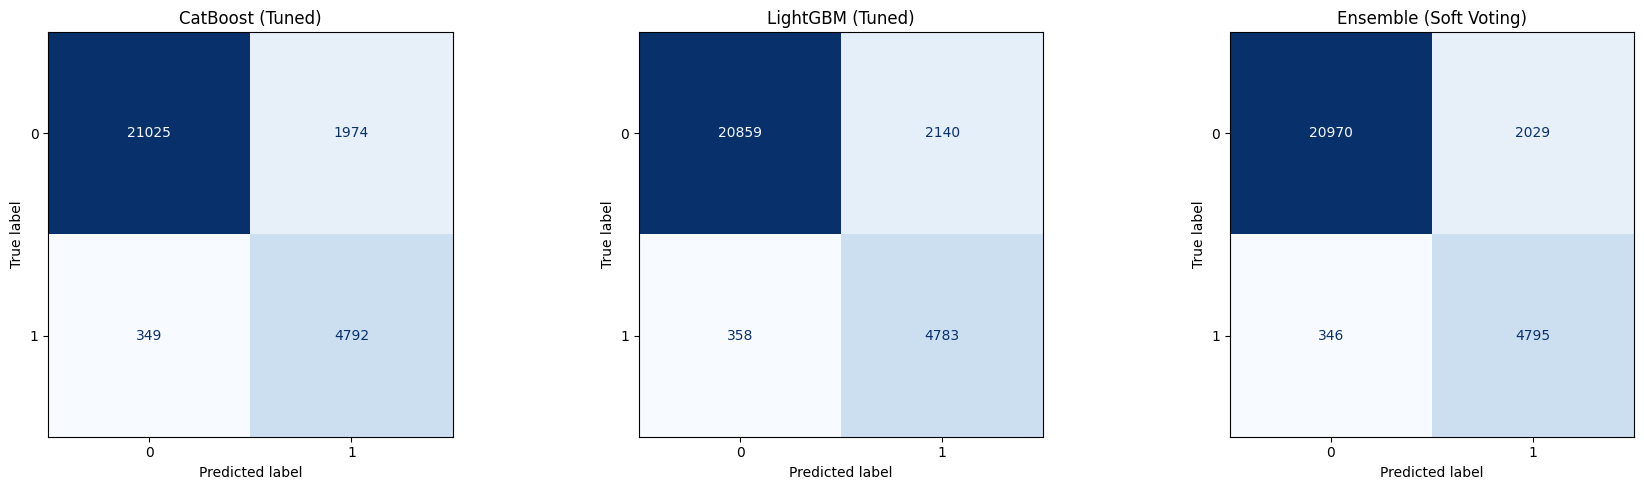

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# CatBoost
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_tuned_cat, ax=axes[0], colorbar=False, cmap="Blues"
)
axes[0].set_title("CatBoost (Tuned)")

# LightGBM
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_tuned_lgb, ax=axes[1], colorbar=False, cmap="Blues"
)
axes[1].set_title("LightGBM (Tuned)")

# Ensemble (Soft Voting)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_manual_soft, ax=axes[2], colorbar=False, cmap="Blues"
)
axes[2].set_title("Ensemble (Soft Voting)")

plt.tight_layout()
plt.show()

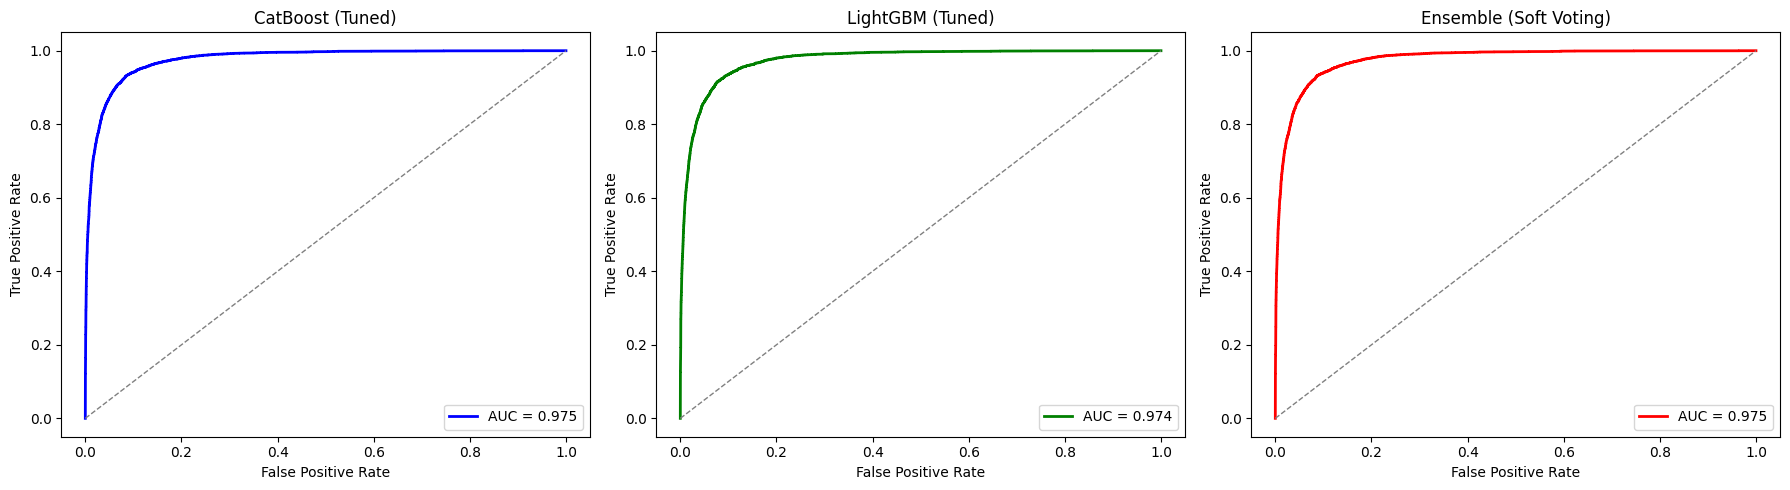

In [38]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# CatBoost ROC
fpr_cat, tpr_cat, _ = roc_curve(y_test, tuned_catmodel.predict_proba(X_test)[:, 1])
roc_auc_cat = auc(fpr_cat, tpr_cat)
axes[0].plot(fpr_cat, tpr_cat, color='blue', lw=2, label=f'AUC = {roc_auc_cat:.3f}')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[0].set_title('CatBoost (Tuned)')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc='lower right')

# LightGBM ROC
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, tuned_lgbmodel.predict_proba(X_test)[:, 1])
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
axes[1].plot(fpr_lgb, tpr_lgb, color='green', lw=2, label=f'AUC = {roc_auc_lgb:.3f}')
axes[1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[1].set_title('LightGBM (Tuned)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')

# Ensemble ROC
fpr_ens, tpr_ens, _ = roc_curve(y_test, avg_proba[:, 1])
roc_auc_ens = auc(fpr_ens, tpr_ens)
axes[2].plot(fpr_ens, tpr_ens, color='red', lw=2, label=f'AUC = {roc_auc_ens:.3f}')
axes[2].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[2].set_title('Ensemble (Soft Voting)')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [36]:
# Calculate wrong predictions for each model
wrong_cat = (y_pred_tuned_cat != y_test).astype(int)
wrong_lgb = (y_pred_tuned_lgb != y_test).astype(int)
wrong_ensemble = (y_pred_manual_soft != y_test).astype(int)

# Count number of wrong predictions for each model
n_wrong_cat = wrong_cat.sum()
n_wrong_lgb = wrong_lgb.sum()
n_wrong_ensemble = wrong_ensemble.sum()

print(f"Wrong predictions - CatBoost: {n_wrong_cat}")
print(f"Wrong predictions - LightGBM: {n_wrong_lgb}")
print(f"Wrong predictions - Ensemble: {n_wrong_ensemble}")

# Find indices where all three models are wrong
all_wrong = ((wrong_cat == 1) & (wrong_lgb == 1) & (wrong_ensemble == 1)).sum()
print(f"Number of samples all three models predict wrong: {all_wrong}")

# # Optionally, count pairwise similarities
# cat_lgb_wrong = ((wrong_cat == 1) & (wrong_lgb == 1)).sum()
# cat_ensemble_wrong = ((wrong_cat == 1) & (wrong_ensemble == 1)).sum()
# lgb_ensemble_wrong = ((wrong_lgb == 1) & (wrong_ensemble == 1)).sum()

# print(f"Number of samples CatBoost & LightGBM both wrong: {cat_lgb_wrong}")
# print(f"Number of samples CatBoost & Ensemble both wrong: {cat_ensemble_wrong}")
# print(f"Number of samples LightGBM & Ensemble both wrong: {lgb_ensemble_wrong}")

Wrong predictions - CatBoost: 2323
Wrong predictions - LightGBM: 2498
Wrong predictions - Ensemble: 2375
Number of samples all three models predict wrong: 2156


Qua các biểu đồ và số liệu về các mẫu bị dự đoán sai giống nhau giữa 3 mô hình, ta có thể phần nào hiểu được tại sao ensemble model có **kết quả không tốt hơn** 2 mô hình con.

Hai mô hình `CatBoost` và `LightGBM` học dữ liệu một cách giống nhau (mắc những sai lầm như nhau). 

Vì thế, ensemble không thể có được hiệu quả cao hơn.